In [1]:
import psycopg2
from IPython.display import Image
import copy
import json
import pydot

from tree_node import TreeNode
from qep_stats import * 
from parse_tree import parseJsonNode, getTreeBFS

In [2]:
def connect(query):
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        host='localhost' #'172.21.148.168'
        database='classicmodels'
        user='signapoop' #'db'
        password='none' #'dbproj'
 
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(host=host,database=database, user=user, password=password)

        cur = conn.cursor()
        cur.execute(query)
        result = cur.fetchall()
        
        # close the communication with the PostgreSQL
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('Database connection closed.')
    return result

In [3]:
# query = \
# "EXPLAIN(ANALYZE, FORMAT JSON) \
# SELECT c.customerNumber, COUNT(*) \
# FROM customers c, orders o, orderdetails od \
# WHERE c.customerNumber = o.customerNumber AND o.orderNumber = od.orderNumber AND od.quantityOrdered > 1 \
# GROUP BY c.customerNumber \
# HAVING COUNT(*) > 4;"

In [70]:
query = \
"EXPLAIN(ANALYZE, FORMAT JSON) select * from customers c, orders o where c.customernumber= o.customernumber group by c.customernumber, o.customernumber, o.ordernumber having count(*) < 10;"

In [71]:
# query = \
# "EXPLAIN(FORMAT JSON) \
# SELECT c.customerNumber, COUNT(*) \
# FROM customers c, orders o, orderdetails od \
# WHERE c.customerNumber > o.customerNumber AND o.orderNumber = od.orderNumber AND od.quantityOrdered > 1 + 3 \
# GROUP BY c.customerNumber \
# HAVING COUNT(*) > 4"

In [72]:
# query = \
# "EXPLAIN (ANALYZE, FORMAT JSON)\
# SELECT o.officecode, o.city, COUNT(*) \
# FROM employees c, offices o \
# WHERE c.officecode = o.officecode \
# GROUP BY o.officecode \
# HAVING COUNT(*) > 1;"

In [73]:
result = connect(query)

Connecting to the PostgreSQL database...
Database connection closed.


In [74]:
print(json.dumps(result[0][0], sort_keys=True, indent=4))

[
    {
        "Execution Time": 1.366,
        "Plan": {
            "Actual Loops": 1,
            "Actual Rows": 326,
            "Actual Startup Time": 0.903,
            "Actual Total Time": 1.128,
            "Filter": "(count(*) < 10)",
            "Group Key": [
                "c.customernumber",
                "o.ordernumber"
            ],
            "Node Type": "Aggregate",
            "Parallel Aware": false,
            "Partial Mode": "Simple",
            "Plan Rows": 109,
            "Plan Width": 243,
            "Plans": [
                {
                    "Actual Loops": 1,
                    "Actual Rows": 326,
                    "Actual Startup Time": 0.148,
                    "Actual Total Time": 0.446,
                    "Hash Cond": "(o.customernumber = c.customernumber)",
                    "Inner Unique": true,
                    "Join Type": "Inner",
                    "Node Type": "Hash Join",
                    "Parallel Aware": false,
    

In [75]:
def plotBFS(root, graph):
    frontier = [root]
    i = 0
    while frontier:
        next_level = []
        for u in frontier:
            #print("level {}, val {}, title {}".format(i, n.val, n.title))
            for v in u.children: 
                edge = pydot.Edge(u.pydot_node, v.pydot_node)
                graph.add_edge(edge)
                next_level.append(v)
        frontier = next_level
        i += 1

def plotQueryTree(query, qep, filename='test.png'):
    assert 'Plan' in qep[0], "Invalid JSON was given"
    root = parseJsonNode(qep[0]['Plan'])
    all_nodes = getTreeBFS(root)
    
    # Compute statistics
    execution_time = qep[0].get('Execution Time', None)
    planning_time = qep[0].get('Planning Time', None)
    calculateActualCost(all_nodes)
    calculateActualDuration(all_nodes)
    largest_row = markLargestNode(all_nodes)
    largest_cost = markCostliestNode(all_nodes)
    largest_duration = markSlowestNode(all_nodes)
    calculatePercentDuration(all_nodes, execution_time)
    
    correlateQuery(all_nodes, query)
    
    stats = {'execution_time': execution_time, 
             'planning_time': planning_time,
             'largest_row': largest_row, 
             'largest_cost': largest_cost, 
             'largest_duration': largest_duration}
    
    graph = pydot.Dot(graph_type='graph')
    for node in all_nodes:
        node.pydot_node = pydot.Node(node.to_string(), shape='box')
        graph.add_node(node.pydot_node)
    plotBFS(all_nodes[0], graph)
    graph.write_png(filename)
    return filename, all_nodes, stats

In [76]:
def stripParenthesis(foo):
    foo = foo.replace("(", '')
    foo = foo.replace(")", '')
    foo = foo.replace('::text', '')
    foo = foo.replace('~~', 'like')
    foo = foo.replace('!~~', 'not like')
    return foo

In [77]:
def findMatchingBE(query, booleans, cond):
    for b in booleans:
        be = BooleanExpression(cond, variables=b.variables, rev_variables=b.rev_variables)
        if isEquivalentBooleanExpression(be, b):
            return b.start, b.end, query[b.start:b.end]
    return -1, -1, ""

In [78]:
from findExpressions import *
from BooleanExpression import BooleanExpression

In [79]:
def reverseComparatorIfNeeded(comparator):
    if comparator == '<':
        return '>'
    elif comparator == '<=':
        return '>='
    return comparator

def isEquivalentBooleanExpression(a,b):
    if not hasattr(a.right, 'exp'):
        if hasattr(a.right, 'val') and hasattr(b.right, 'val'):
            return a.left.exp==b.left.exp and a.right.val==b.right.val
    elif a.left.exp==b.left.exp and a.right.exp==b.right.exp:
        return a.comparator==b.comparator
    elif a.left.exp==b.right.exp and a.right.exp==b.left.exp:
        return a.comparator==reverseComparatorIfNeeded(b.comparator)
    
    return False

In [80]:
def getMatchingClause(query, search_key):
    start = query.find(search_key)
    if start == -1:
        return start
    shortened_query = query[start+len(search_key)+1:]
    parts = shortened_query.split(' ') 
    return search_key + ' ' + parts[0]

In [81]:
def findClauseStartEnd(query, clause):
    start = query.find(clause)
    if start == -1:
        return -1, -1, ""
    return start, start + len(clause), clause

In [102]:
def correlateQuery(all_nodes, query):
    
    # Change query to a list of Boolean expressions
    query = query.lower()
    booleans = findExpressions(query)
    
    for node in all_nodes:
        #print(node.title)
        s = -1
        e = -1
        if 'Join' in node.title:
            # Find hash condition as boolean expression
            cond = stripParenthesis(node.description_dict['Hash Cond'])
            s, e, match = findMatchingBE(query, booleans, cond)
            print('Join:', cond, 'Matched: ', match)
            
        elif 'Scan' in node.title:
            # Find relation name
            clause = " ".join([node.description_dict['Relation Name'], node.description_dict['Alias']])
            s, e, match = findClauseStartEnd(query, clause.lower())
            print('Scan:', clause, 'Matched: ', match)
            if 'Filter' in node.description_dict:
                # Find filter condition as boolean expression
                cond = stripParenthesis(node.description_dict['Filter'])
                s, e, match = findMatchingBE(query, booleans, cond)
                print('Filter:', cond, 'Matched: ', match)
                
        elif 'Aggregate' in node.title:
            # Find GROUP BY
            clause = getMatchingClause(query, 'group by')
            s, e, match = findClauseStartEnd(query, clause)
            print('Aggregate:', 'Matched: ', match)
        
        elif 'Sort' in node.title:
            clause = getMatchingClause(query, 'order by')
            s, e, match = findClauseStartEnd(query, clause)
            print('Sort:', 'Matched: ', match)
        
        elif 'Limit' in node.title:
            clause = getMatchingClause(query, 'limit')
            s, e, match = findClauseStartEnd(query, clause)
            print('Limit:', 'Matched: ', match)
            
        node.description_dict['StartOfQuery'] = s
        node.description_dict['EndOfQuery'] = e
        
#correlateQuery(all_nodes, query)

In [103]:
qep = result[0][0]
filename, all_nodes, stats = plotQueryTree(query, qep)
print(stats)

Aggregate: Matched:  group by c.customernumber,
Join: o.customernumber = c.customernumber Matched:  c.customernumber= o.customernumber
Scan: orders o Matched:  orders o
Scan: customers c Matched:  customers c
{'execution_time': 1.366, 'planning_time': 4.978, 'largest_row': 326, 'largest_cost': 7.26, 'largest_duration': 0.6819999999999999}


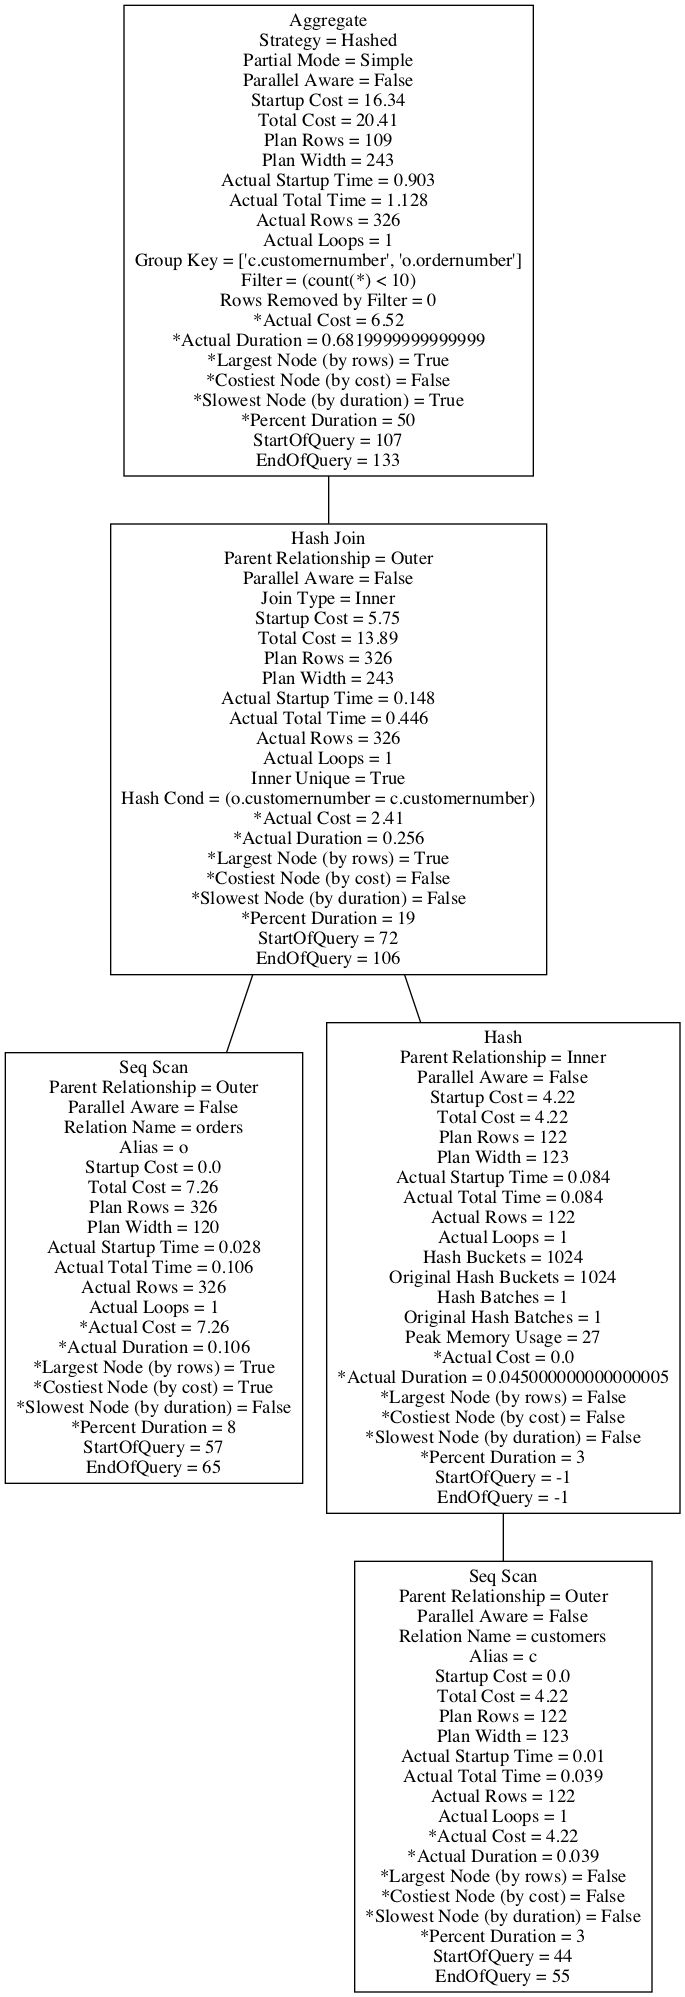

In [86]:
Image(filename)

In [87]:
with open('stats.json', 'w') as outfile:
    json.dump(stats, outfile)

with open('qep.json', 'w') as outfile:
    json.dump(all_nodes[0].to_json(), outfile, indent=4)

In [99]:
query

'EXPLAIN(ANALYZE, FORMAT JSON) select * from customers c, orders o where c.customernumber= o.customernumber group by c.customernumber, o.customernumber, o.ordernumber having count(*) < 10;'